# <h1 align="center"> **PALAS - Sistema de Informações de Investigação** <h1/>

## **Coleta de Dados e Metodologia**


Os dados foram coletados no site Portal de Dados Abertos (dados.gov.br) e traz informações sobre operações da Polícia Federal deflagradas em todo o território nacional, nos anos de 2022 e 2023. 

Neste estudo, farei uma análise para verificar os tipos de operações com maior potencial de sucesso, como um grande volume de apreensões ou quantidade de prisões realizadas. Também verificarei se as fronteiras com os países vizinhos podem influenciar o resultado das ações policiais de alguma maneira.

## **Automatização da Leitura dos Arquivos e Tratamento dos Dados**

Os dados estão divididos em 24 arquivos csv, 1 para cada mês de 2022 e 2023. As seguintes funções foram criadas em Python para automatizar o processo de criação do Dataframe:

 - **data_wrangling**: seleciona e renomeia as features desejadas, limpa e converte valores das colunas;
 
 - **read_n_clean**: faz a leitura do arquivo csv e todos os processos de data_wrangling();
 
 - **concatenate_all**: concatena todos os arquivos csv por ano;

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
print('OK')

OK


In [3]:
def data_wrangling(df):
    # Colunas selecionadas
    fed_df = df[['Data do Inicio', 'Data da Deflagracao', 'Tipo de Operacao', 'Area', 'Sigla Unidade Federativa', 'Atuacao em Territorio de Fronteira', 'Qtd Prisao em Flagrante', 
                 'Qtd Prisao Preventiva', 'Qtd Prisao Temporaria', 'Qtd Mandado de Busca e Apreesao', 'Qtd Valores Apreendidos', 'Qtd Prejuizos Causados a Uniao']]
    
    # Renomear colunas
    fed_df = fed_df.rename(columns={'Area':'Crime', 'Sigla Unidade Federativa':'UF', 'Atuacao em Territorio de Fronteira':'Fronteira', 
                                    'Qtd Prisao em Flagrante':'Prisao Flagrante', 'Qtd Prisao Preventiva':'Prisao Preventiva', 'Qtd Prisao Temporaria':'Prisao Temporaria', 
                                    'Qtd Mandado de Busca e Apreesao':'Mandados', 'Qtd Valores Apreendidos':'Valores Apreendidos (R$)', 
                                    'Qtd Prejuizos Causados a Uniao':'Prejuizos a Uniao (R$)'})
    
    # Limpar dados de 'Area'
    for num, item in enumerate(fed_df['Crime']):
        new_item = " ".join(item.split())
        fed_df.iloc[num, 3] = new_item
    
    # Limpar dados de 'Fronteira'
    for num, item in enumerate(fed_df['Fronteira']):
        new_item = " ".join(item.split())
        if new_item == '':
            new_item = 'Não'
        fed_df.iloc[num, 5] = new_item
    
    # Transformar NaN em 0
    fed_df = fed_df.fillna(0)
    
    # Apenas valores numéricos em 'Valores Apreendidos (R$)'
    for num, item in enumerate(fed_df['Valores Apreendidos (R$)']):
        if item != 0:
            item_novo = item.strip('R$')
            item_novo = item_novo.replace('.', '').replace(',','.')
            fed_df.iloc[num,10] = item_novo
    
    # Apenas valores numéricos em 'Prejuizos a Uniao (R$)'
    for num, item in enumerate(fed_df['Prejuizos a Uniao (R$)']):
        if item != 0:
            item_novo = item.strip('R$')
            item_novo = item_novo.replace('.', '').replace(',','.')
            fed_df.iloc[num,11] = item_novo
    
    # Converter object em float
    fed_df['Valores Apreendidos (R$)'] = fed_df['Valores Apreendidos (R$)'].astype('float')
    fed_df['Prejuizos a Uniao (R$)'] = fed_df['Prejuizos a Uniao (R$)'].astype('float')
    
    # Apenas dados de Tráfico de Drogas
    # fed_df = fed_df[fed_df['Area'] == 'Tráfico de Drogas']
    
    # Retirar coluna 'Area'
    # fed_df.drop('Area', axis=1, inplace=True)
    
    # Converter datas para DateTime
    fed_df['Data da Deflagracao'] = pd.to_datetime(fed_df['Data da Deflagracao'], dayfirst=True)
    fed_df['Data do Inicio'] = pd.to_datetime(fed_df['Data do Inicio'], dayfirst=True)
    
    return fed_df
    

In [5]:
def read_n_clean(path):
    df_raw = pd.read_csv(path, sep=';', encoding='ANSI')
    df = data_wrangling(df_raw)
    return df

In [7]:
ano = []
def concatenate_all(year):
    # Excluir tudo de lista 'ano'
    ano.clear()
    
    # Transformar os ints em strs
    for juntar in range(1, 13):
        if len(str(juntar)) < 2:
            juntar = '0' + str(juntar)
        else:
            juntar = str(juntar)
        
        # Ler, limpar e adicionar na lista 'ano'
        juntar = read_n_clean("PALAS/PF" + year + "/PALAS_OPERACOES_" + year + "_" + juntar + ".csv")
        ano.append(juntar)
    
    df = pd.concat(ano)
    return df

In [9]:
# Criar Dataframe do ano de 2022
fed_2022 = concatenate_all('2022')

In [11]:
# Colunas para definir qual ano as operações aconteceram (2022)
fed_2022["Ano_22"] = 1
fed_2022["Ano_23"] = 0

In [13]:
fed_2022.shape

(10268, 14)

In [15]:
fed_2022.head()

,Data do Inicio,Data da Deflagracao,Tipo de Operacao,Crime,UF,Fronteira,Prisao Flagrante,Prisao Preventiva,Prisao Temporaria,Mandados,Valores Apreendidos (R$),Prejuizos a Uniao (R$),Ano_22,Ano_23
0,2019-06-04,2022-01-31,Operacao Especial,Crimes de Ódio e Pornografia Infantil,RR,Não,0,0,0,1,0.0,0.0,1,0
1,2021-10-21,2022-01-31,Operacao Especial,Fraudes Bancárias,MG,Não,0,0,0,15,393625.0,393625.0,1,0
2,2022-01-31,2022-01-31,Operacao Comum,Fraudes Bancárias,MG,Não,0,0,0,2,0.0,0.0,1,0
3,2022-01-31,2022-01-31,Operacao de Apoio,Tráfico de Drogas,PI,Não,0,0,0,0,0.0,0.0,1,0
4,2022-01-31,2022-01-31,Operacao Simples,Crimes Fazendários,RS,Não,0,0,0,0,207753.0,50000.0,1,0


In [17]:
# Criar Dataframe do ano de 2023
fed_2023 = concatenate_all('2023')

In [19]:
# Colunas para definir qual ano as operações aconteceram (2023)
fed_2023["Ano_22"] = 0
fed_2023["Ano_23"] = 1

In [21]:
fed_2023.shape

(9337, 14)

In [23]:
fed_2023.head()

,Data do Inicio,Data da Deflagracao,Tipo de Operacao,Crime,UF,Fronteira,Prisao Flagrante,Prisao Preventiva,Prisao Temporaria,Mandados,Valores Apreendidos (R$),Prejuizos a Uniao (R$),Ano_22,Ano_23
0,2021-05-21,2023-01-31,Operacao Especial,Crimes Fazendários,GO,Não,0,0,0,3,0.0,0.0,0,1
1,2022-08-22,2023-01-31,Operacao Especial,Crimes Fazendários,MS,Paraguai,0,0,0,3,2697.0,0.0,0,1
2,2022-09-26,2023-01-31,Operacao Especial,Crimes Fazendários,RN,Não,0,0,0,1,2000.0,0.0,0,1
3,2022-10-25,2023-01-31,Operacao Especial,Tráfico de Drogas,AP,Não,0,0,0,3,4350.0,0.0,0,1
4,2023-01-30,2023-01-31,Operacao Simples,Tráfico de Drogas,PR,Paraguai,0,0,0,0,187700.0,0.0,0,1


In [25]:
# Concatenar Dataframes de 2022 e 2023
df_fed = pd.concat([fed_2022, fed_2023], ignore_index=True)
df_fed.shape

(19605, 14)

In [27]:
df_fed.dtypes

Data do Inicio              datetime64[ns]
Data da Deflagracao         datetime64[ns]
Tipo de Operacao                    object
Crime                               object
UF                                  object
Fronteira                           object
Prisao Flagrante                     int64
Prisao Preventiva                    int64
Prisao Temporaria                    int64
Mandados                             int64
Valores Apreendidos (R$)           float64
Prejuizos a Uniao (R$)             float64
Ano_22                               int64
Ano_23                               int64
dtype: object

In [29]:
df_fed.isnull().sum()

Data do Inicio              0
Data da Deflagracao         0
Tipo de Operacao            0
Crime                       0
UF                          0
Fronteira                   0
Prisao Flagrante            0
Prisao Preventiva           0
Prisao Temporaria           0
Mandados                    0
Valores Apreendidos (R$)    0
Prejuizos a Uniao (R$)      0
Ano_22                      0
Ano_23                      0
dtype: int64

In [31]:
df_fed['Valores Apreendidos (R$)'].describe()

count    1.960500e+04
mean     5.534840e+05
std      1.430564e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.000000e+03
max      1.431200e+09
Name: Valores Apreendidos (R$), dtype: float64

In [33]:
# Criar novo arquivo csv limpo e concatenado
df_fed.to_csv("PALAS/operacoes_22_23.csv", sep=",", encoding="utf-8", index=False)

## **Exploratory Data Analysis com SQL**

O arquivo *operacoes_22_23.csv*, limpo e tratado, possui 19605 linhas e 14 features. Através de consultas com a linguagem SQL e data visualization, pretendo extrair informações pertinentes aos objetivos citados no tópico anterior, entre elas:

- Quantidade total de operações, por crime, em cada ano;

- Total de prisões (contabilizando flagrante, preventiva e temporária) por tipo de operação;

- Total de prisões (contabilizando flagrante, preventiva e temporária) por crime;

- Total de operações de fronteira por crime;

- As 10 maiores operações não-fronteiriças em valores apreendidos;

- As 10 maiores operações em valores apreendidos em fronteira;

- As 10 maiores operações não-fronteiriças em prejuízos à União;

- As 10 maiores operações em prejuízos à União em fronteira;

- Quantidade de operações por Estado;

- Os 10 Estados com maior quantidade de operação em fronteira;

- As 10 operações mais longas (tempo entre data de início e data de deflagração);

- As 10 operações mais curtas (tempo entre data de início e data de deflagração).

In [9]:
# Ler arquivo csv
df = pd.read_csv('PALAS/operacoes_22_23.csv')
df.shape

(19605, 14)

In [11]:
df['Data do Inicio'] = pd.to_datetime(df['Data do Inicio'])
df['Data da Deflagracao'] = pd.to_datetime(df['Data da Deflagracao'])
df.dtypes

Data do Inicio              datetime64[ns]
Data da Deflagracao         datetime64[ns]
Tipo de Operacao                    object
Crime                               object
UF                                  object
Fronteira                           object
Prisao Flagrante                     int64
Prisao Preventiva                    int64
Prisao Temporaria                    int64
Mandados                             int64
Valores Apreendidos (R$)           float64
Prejuizos a Uniao (R$)             float64
Ano_22                               int64
Ano_23                               int64
dtype: object

In [13]:
df.head()

,Data do Inicio,Data da Deflagracao,Tipo de Operacao,Crime,UF,Fronteira,Prisao Flagrante,Prisao Preventiva,Prisao Temporaria,Mandados,Valores Apreendidos (R$),Prejuizos a Uniao (R$),Ano_22,Ano_23
0,2019-06-04,2022-01-31,Operacao Especial,Crimes de Ódio e Pornografia Infantil,RR,Não,0,0,0,1,0.0,0.0,1,0
1,2021-10-21,2022-01-31,Operacao Especial,Fraudes Bancárias,MG,Não,0,0,0,15,393625.0,393625.0,1,0
2,2022-01-31,2022-01-31,Operacao Comum,Fraudes Bancárias,MG,Não,0,0,0,2,0.0,0.0,1,0
3,2022-01-31,2022-01-31,Operacao de Apoio,Tráfico de Drogas,PI,Não,0,0,0,0,0.0,0.0,1,0
4,2022-01-31,2022-01-31,Operacao Simples,Crimes Fazendários,RS,Não,0,0,0,0,207753.0,50000.0,1,0


In [8]:
# Estabelecer conexão com database
con = sqlite3.connect('dataframe_01.db')

In [9]:
# Criar table "FEDERAL"
df.to_sql('FEDERAL', con)

19605

In [10]:
# Load do módulo sql
%load_ext sql

In [12]:
# Associar ao Database criado
%sql sqlite:///dataframe_01.db

 - #### Quantidade total de operações, por crime, em cada ano

In [501]:
# Quantidade total de operações, por crime, em 2022 -> transformar em dataframe
df_crimes22 = pd.read_sql_query("SELECT Crime, count(*) as 'Total', Ano_22 FROM FEDERAL WHERE Ano_22 = 1 GROUP BY Crime", con=con)

In [503]:
# Quantidade total de operações, por crime, em 2023 -> transformar em dataframe
df_crimes23 = pd.read_sql_query("SELECT Crime, count(*) as 'Total', Ano_23 FROM FEDERAL WHERE Ano_23 = 1 GROUP BY Crime", con=con)

In [505]:
# Adicionar Assuntos Internos em 2023
df_crimes23.loc[-1] = ['Assuntos Internos', 0, 1]  # adicionar row
df_crimes23.index = df_crimes23.index + 1  # mudar index
df_crimes23.sort_index(inplace=True) # organizar index

In [507]:
# Criar DFs novos com colunas desejadas e concatenar
df_crimes = df_crimes22[['Crime', 'Total']]
df_crimes = df_crimes.rename(columns={'Total':'2022'})

df_23 = df_crimes23[['Total']]
df_23 = df_23.rename(columns={'Total':'2023'})

df_crimes = pd.concat([df_crimes, df_23], axis=1)
df_crimes.set_index('Crime', inplace=True)

In [509]:
df_crimes.sort_values('2022', axis=0, ascending=False, inplace=True)
df_crimes

,2022,2023
Crime,,
Crimes Fazendários,3980,2891
Tráfico de Drogas,2948,2947
Crimes Ambientais e Contra o Patrimônio Cultural,868,622
Crimes Contra o Patrimônio,505,399
Crimes de Corrupção,440,583
Crimes de Ódio e Pornografia Infantil,412,885
Crimes Contra Direitos Humanos,298,258
Crimes Eleitorais,251,48
Crimes Financeiros,180,204


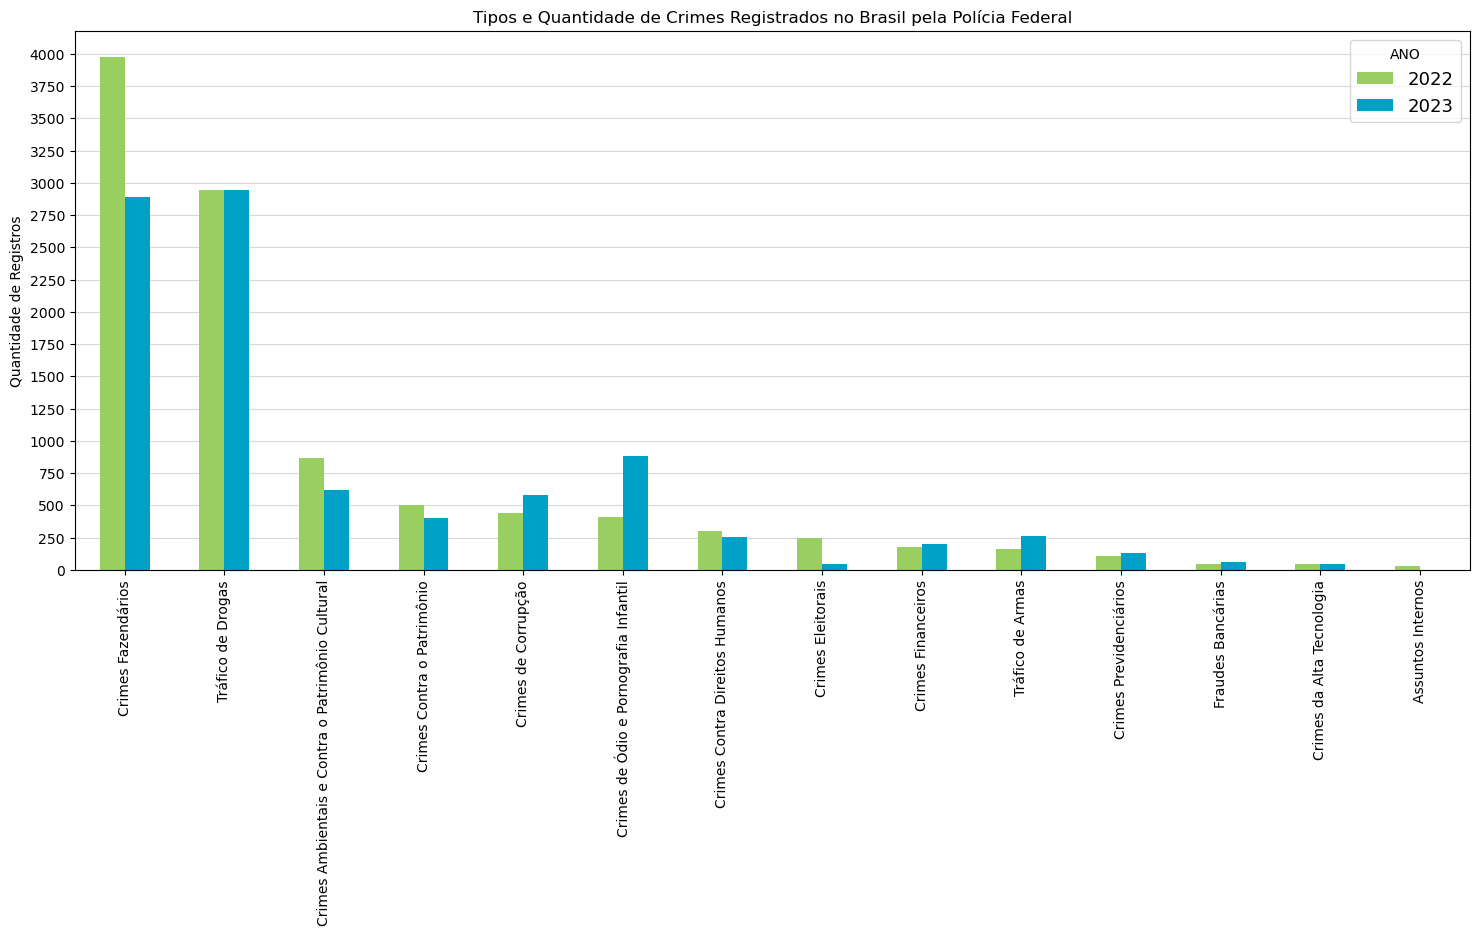

In [78]:
cores = ['#99ce60', '#00A1C6']
df_crimes.plot(kind='bar', color=cores, figsize=(18,7))
plt.title("Tipos e Quantidade de Crimes Registrados no Brasil pela Polícia Federal")
plt.ylabel("Quantidade de Registros")
plt.yticks(range(0, 4001, 250))
plt.xlabel(None)
plt.legend(title='ANO', fontsize=13)
plt.grid(axis="y", alpha=0.5, zorder=0)
plt.gca().set_axisbelow(True)

**Aumento de Crimes de Ódio e Pornografia Infantil & Diminuição de Crimes Eleitorais**

A análise de tipos de crime por ano indica uma diminuição significativa de crimes eleitorais de 2022 para 2023. A queda drástica para cerca de 1/5 (um quinto) dos registros do ano anterior é compreensível, considerando que 2022 foi um ano de eleições.

Por outro lado, os crimes de ódio e pornografia infantil duplicaram no período analisado. Como a categoria envolve dois tipos muito distintos de crime, é preciso uma análise mais profunda de ambos os tipos de infração para mais afirmações.

O último ponto notável é a queda em crimes fazendários, categoria que também envolve uma série de infrações diferentes.

- #### Total de prisões (contabilizando flagrante, preventiva e temporária) por tipo de operação

In [11]:
%%sql 
SELECT [Tipo de Operacao], sum([Prisao Flagrante]) as "Prisão Flagrante", sum([Prisao Preventiva]) as "Prisão Preventiva", sum([Prisao Temporaria]) as "Prisão Temporária" 
FROM FEDERAL 
GROUP BY [Tipo de Operacao];

 * sqlite:///dataframe_01.db
Done.


Tipo de Operacao,Prisão Flagrante,Prisão Preventiva,Prisão Temporária
Operacao Comum,850,281,25
Operacao Especial,1071,2205,722
Operacao Simples,4194,345,8
Operacao de Apoio,0,0,0


In [13]:
prisoes = pd.read_sql_query('SELECT [Tipo de Operacao], sum([Prisao Flagrante]) as "Prisão Flagrante", sum([Prisao Preventiva]) as "Prisão Preventiva", sum([Prisao Temporaria]) as "Prisão Temporária" FROM FEDERAL GROUP BY [Tipo de Operacao]', con=con)

In [15]:
prisoes.set_index('Tipo de Operacao', inplace=True)

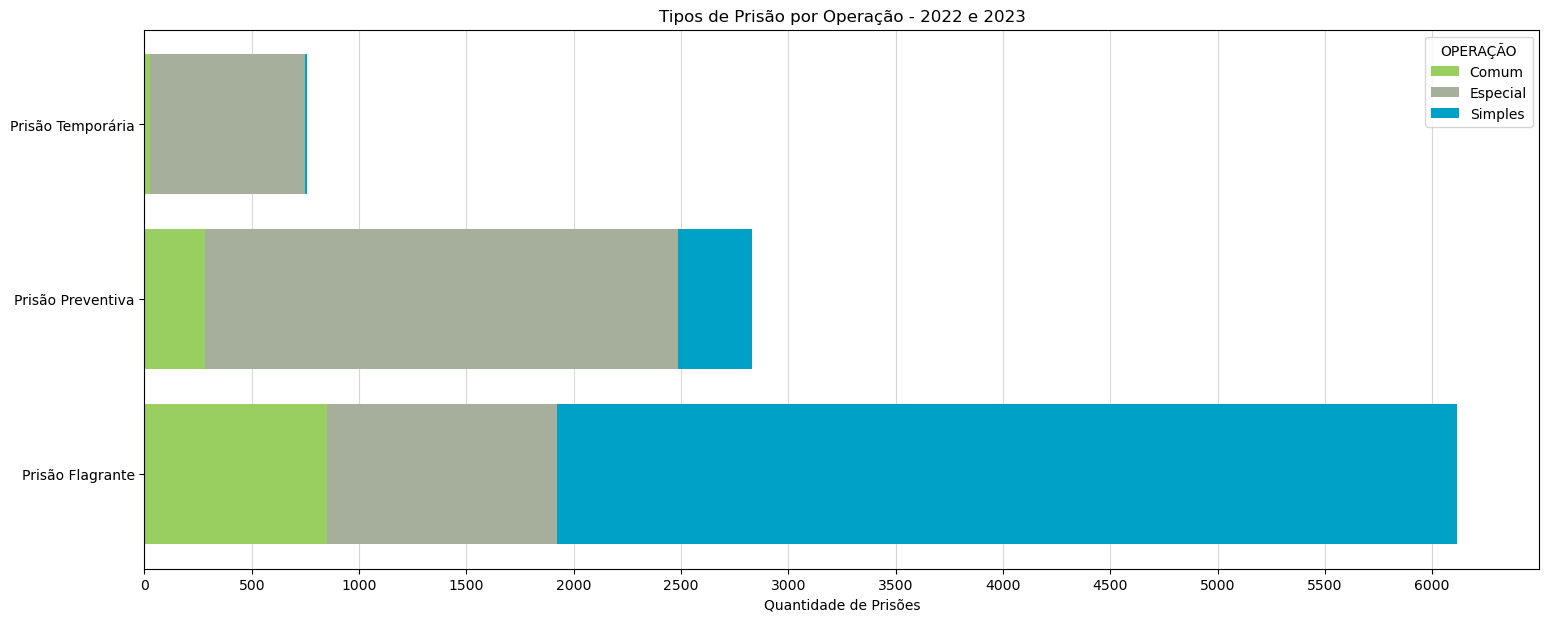

In [17]:
# Preparar Dataframe para gráfico stacker
tipos = []
for prisao in prisoes:
    if prisao != 'Apoio':
        tipos.append(prisao)
    else:
        break

valor_array = np.array(prisoes)

dict_prisoes = {
    "Comum":valor_array[0],
    "Especial":valor_array[1],
    "Simples":valor_array[2],
}

fundo = np.zeros(3)

# Stacker Bar
cores = ['#99ce60', '#A6AE9C', '#00A1C6']
cor = 0

fig, ax = plt.subplots(figsize=(18,7))
for nome, cont in dict_prisoes.items():
    ax.barh(tipos, cont, label=nome, left=fundo, color=cores[cor])
    fundo += cont
    cor += 1
    
ax.set_title('Tipos de Prisão por Operação - 2022 e 2023')
ax.legend(title='OPERAÇÃO')
plt.xlim(0, 6500)
plt.xticks(range(0, 6001, 500))
plt.xlabel('Quantidade de Prisões')
plt.grid(axis="x", alpha=0.5, zorder=0)
plt.gca().set_axisbelow(True)

- #### Total de prisões (contabilizando flagrante, preventiva e temporária) por crime

In [19]:
%%sql 
SELECT Crime, sum([Prisao Flagrante]) as "Prisão Flagrante", sum([Prisao Preventiva]) as "Prisão Preventiva", sum([Prisao Temporaria]) as "Prisão Temporária" 
FROM FEDERAL 
GROUP BY Crime 
ORDER BY sum([Prisao Flagrante]) DESC;

 * sqlite:///dataframe_01.db
Done.


Crime,Prisão Flagrante,Prisão Preventiva,Prisão Temporária
Tráfico de Drogas,2449,1503,375
Crimes Fazendários,1886,370,80
Crimes de Ódio e Pornografia Infantil,537,198,14
Crimes Ambientais e Contra o Patrimônio Cultural,509,94,55
Tráfico de Armas,232,33,25
Crimes Contra o Patrimônio,230,397,75
Crimes Previdenciários,81,96,53
Crimes Contra Direitos Humanos,72,53,5
Crimes Eleitorais,44,3,1
Crimes Financeiros,34,34,31


In [696]:
prisao_crime = pd.read_sql_query('SELECT Crime, sum([Prisao Flagrante]) as "Prisão Flagrante", sum([Prisao Preventiva]) as "Prisão Preventiva", sum([Prisao Temporaria]) as "Prisão Temporária" FROM FEDERAL GROUP BY Crime ORDER BY sum([Prisao Flagrante]) DESC LIMIT 5', con=con)
prisao_crime.set_index('Crime', inplace=True)

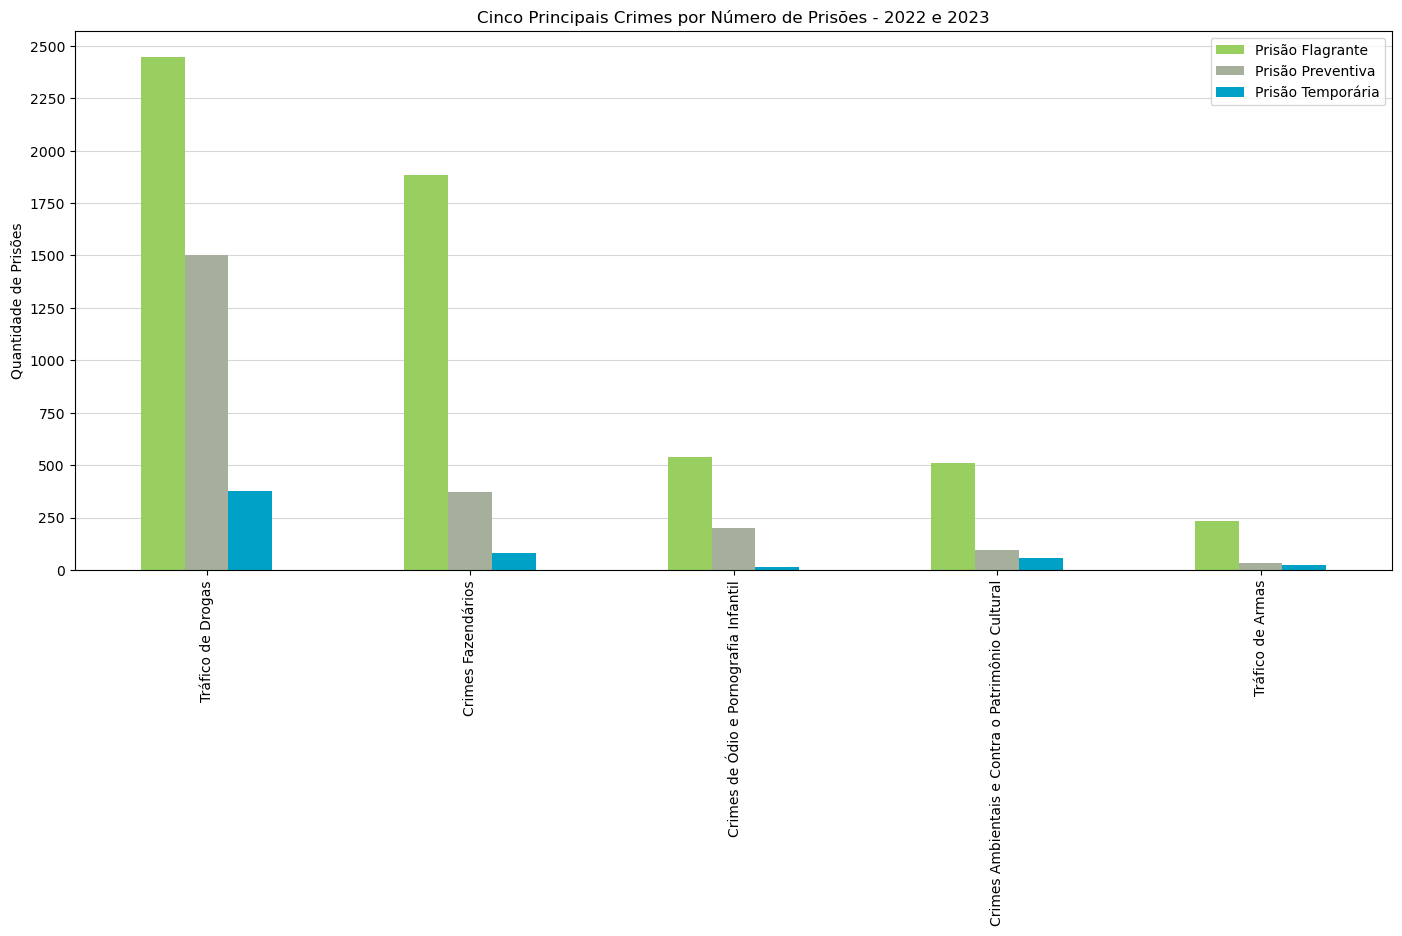

In [698]:
cores = ['#99ce60', '#A6AE9C', '#00A1C6']
prisao_crime.plot(kind='bar', color=cores, figsize=(17,7))
plt.title("Cinco Principais Crimes por Número de Prisões - 2022 e 2023")
plt.ylabel("Quantidade de Prisões")
plt.yticks(range(0, 2750, 250))
plt.xlabel(None)
plt.grid(axis='y', alpha=0.5, zorder=0)
plt.gca().set_axisbelow(True)

In [648]:
# Dataframe com total de prisões, incluindo Flagrante, Preventiva e Temporária em todas as categorias de crime
prisao_total = pd.read_sql_query('SELECT Crime, sum([Prisao Flagrante]) as "Prisão Flagrante", sum([Prisao Preventiva]) as "Prisão Preventiva", sum([Prisao Temporaria]) as "Prisão Temporária" FROM FEDERAL GROUP BY Crime ORDER BY Crime DESC', con=con)

In [650]:
# Somar valores de colunas Flagrante, Preventiva e Temporaria em nova coluna Total de Prisoes
prisao_total['Total de Prisoes'] = 0
for num in range(0, len(prisao_total)):
    prisoes = list(prisao_total.iloc[num, [1, 2, 3]])
    prisao_total.loc[num, 'Total de Prisoes'] = sum(prisoes)

In [652]:
# Usar Dataframe df_crimes para criar novo DF e somar valores de crimes de 2022 e 2023 por categoria de crime
crimes_total = df_crimes.reset_index()

crimes_total['Total de Ocorrencias'] = 0
for num in range(0, len(crimes_total)):
    ocorr = list(crimes_total.iloc[num, [1, 2]])
    crimes_total.loc[num, 'Total de Ocorrencias'] = sum(ocorr)

In [654]:
# Remover colunas desnecessárias e concatenar dataframes
prisao_total.drop(['Prisão Flagrante', 'Prisão Preventiva', 'Prisão Temporária'], axis=1, inplace=True)
crimes_total.drop(['2022', '2023'], axis=1, inplace=True)

relacao_pc = pd.merge(prisao_total, crimes_total, on='Crime')

In [656]:
# Adicionar coluna com relação prisão/ocorrência
relacao_pc['Prisao por Ocorrencias'] = 0
for num in range(0, len(relacao_pc)):
    prisoes = relacao_pc.iloc[num, 1]
    ocorrencias = relacao_pc.iloc[num, 2]
    relacao = round((prisoes/ocorrencias), 2)
    final = relacao.astype('float64')
    relacao_pc.loc[num, 'Prisao por Ocorrencias'] = final

C:\Users\User\AppData\Local\Temp\ipykernel_10140\3885570304.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.73' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  relacao_pc.loc[num, 'Prisao por Ocorrencias'] = final


In [658]:
relacao_pc.sort_values('Prisao por Ocorrencias', axis=0, ascending=False, inplace=True)
relacao_pc

,Crime,Total de Prisoes,Total de Ocorrencias,Prisao por Ocorrencias
6,Crimes Previdenciários,230,240,0.96
10,Crimes Contra o Patrimônio,702,904,0.78
0,Tráfico de Drogas,4327,5895,0.73
1,Tráfico de Armas,290,420,0.69
3,Crimes de Ódio e Pornografia Infantil,749,1297,0.58
13,Assuntos Internos,13,29,0.45
12,Crimes Ambientais e Contra o Patrimônio Cultural,658,1490,0.44
8,Crimes Fazendários,2336,6871,0.34
7,Crimes Financeiros,99,384,0.26
2,Fraudes Bancárias,26,107,0.24


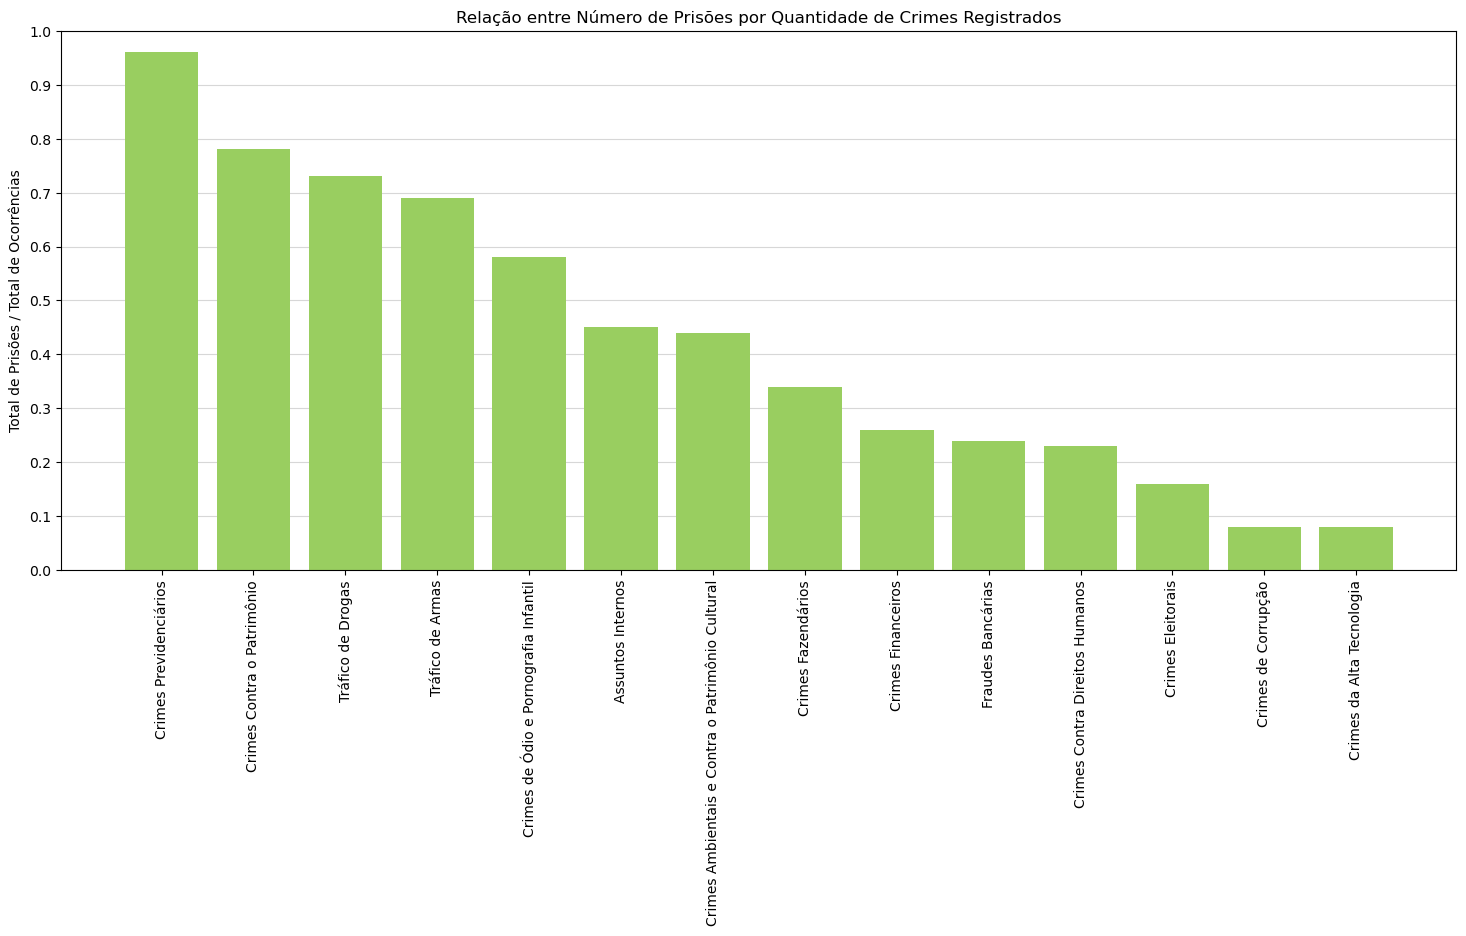

In [690]:
cores = ['#99ce60']
ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

plt.figure(figsize=(18,7))
plt.bar(x='Crime', height='Prisao por Ocorrencias', color=cores, data=relacao_pc)
plt.title("Relação entre Número de Prisões por Quantidade de Crimes Registrados")
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel('Total de Prisões / Total de Ocorrências')
plt.ylim(0, 1)
plt.yticks(ticks)
plt.grid(axis='y', alpha=0.5)
plt.gca().set_axisbelow(True)

**Número de prisões - duas análises, dois resultados bem distintos**

O total de registros por crime e o total de prisões por crime no período (2022 e 2023) têm colocações muito próximas, com **Tráfico de Drogas** e **Crimes Fazendários** nas **primeiras colocações** em ambas as categorias, intercalando entre primeiro e segundo lugar.<br>

Porém, quando calculada a **relação prisões/número de crimes registrados**, há algumas mudanças significativas: as categorias mais "eficientes" em detenções são **Crimes Previdenciários**, com 0,96 prisões por ocorrência, e **Crimes Contra o Patrimômio**, marcando 0,78. **Crimes Fazendários caem para a oitava colocação**.

Analisando ainda a relação prisão/crime, é perceptível a **baixíssima quantidade de prisões em crimes de colarinho branco**, como Crimes Financeiros, Fraudes Bancárias, Crimes de Corrupção e de Alta Tecnologia.

As detenções, por sua vez, acontecem em sua grande maioria por **Prisões em Flagrante**, independente do tipo de crime praticado. Destas, **70%** acontecem durante **Operações Simples**.

In [373]:
# Criar Dataframe contendo prisões por Crime de Ódio e Pornografia Infantil
prisoes_odio = pd.read_sql_query("SELECT strftime('%m', [Data da Deflagracao]) as 'Mês', sum([Prisao Flagrante]) as 'Flag', sum([Prisao Preventiva]) as 'Prev', sum([Prisao Temporaria]) as 'Temp' FROM FEDERAL WHERE Crime = 'Crimes de Ódio e Pornografia Infantil' GROUP BY strftime('%m', [Data da Deflagracao]), Ano_23 ORDER BY Ano_23, Mês", con=con)

In [409]:
# Somar prisões de cada linha e criar lista
lista_total = []
for num in range(0, 24):
    lista = list(prisoes_odio.iloc[num, [1, 2, 3]])
    lista_total.append(sum(lista))
print(lista_total)

[7, 37, 3, 15, 34, 16, 21, 28, 13, 30, 42, 31, 41, 24, 18, 20, 58, 29, 28, 26, 42, 60, 86, 40]


In [411]:
# Dataframe dos casos de Crimes de Ódio e Pornografia Infantil agregados por mês
linha_odio = pd.read_sql_query("SELECT strftime('%m', [Data da Deflagracao]) as 'Mês', count(Crime) as 'Registros' FROM FEDERAL WHERE Crime = 'Crimes de Ódio e Pornografia Infantil' GROUP BY strftime('%m', [Data da Deflagracao]), Ano_23 ORDER BY Ano_23, Mês", con=con)

In [413]:
# Renomear coluna mês:
mes_escrito = ['_', 'Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'] 

for conta, item in enumerate(linha_odio['Mês']):
    num = int(item)
    if conta <= 11:
        ano = '2022'
    else:
        ano = '2023'
    linha_odio.iloc[conta, 0] = mes_escrito[num] + "\n" + ano        

In [415]:
# Criar listas com mes/ano e número de crimes de ódio
lista_mes = list(linha_odio['Mês'])
lista_registros = list(linha_odio['Registros'])
print(lista_mes)
print(lista_registros)

['Jan\n2022', 'Fev\n2022', 'Mar\n2022', 'Abr\n2022', 'Mai\n2022', 'Jun\n2022', 'Jul\n2022', 'Ago\n2022', 'Set\n2022', 'Out\n2022', 'Nov\n2022', 'Dez\n2022', 'Jan\n2023', 'Fev\n2023', 'Mar\n2023', 'Abr\n2023', 'Mai\n2023', 'Jun\n2023', 'Jul\n2023', 'Ago\n2023', 'Set\n2023', 'Out\n2023', 'Nov\n2023', 'Dez\n2023']
[16, 42, 6, 27, 46, 29, 27, 48, 43, 40, 46, 42, 63, 43, 34, 54, 117, 65, 56, 31, 71, 136, 147, 68]


In [419]:
# Dataframes com 5 Estados com mais crimes de ódio em 2022 e 2023
odio_22 = pd.read_sql_query("SELECT UF, count(*) as 'Estado' FROM FEDERAL WHERE Crime = 'Crimes de Ódio e Pornografia Infantil' AND Ano_22 = 1 GROUP BY UF ORDER BY Estado DESC LIMIT 5", con=con)
odio_23 = pd.read_sql_query("SELECT UF, count(*) as 'Estado' FROM FEDERAL WHERE Crime = 'Crimes de Ódio e Pornografia Infantil' AND Ano_22 = 0 GROUP BY UF ORDER BY Estado DESC LIMIT 5", con=con)

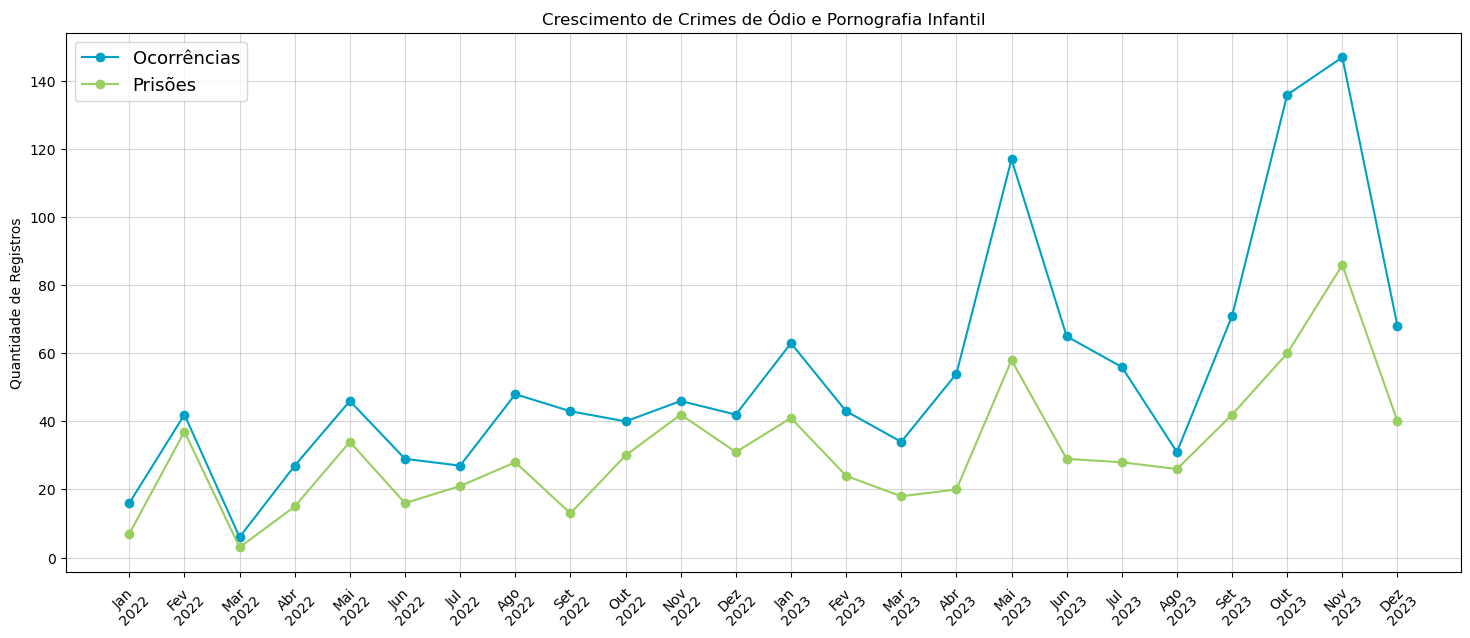

In [437]:
plt.figure(figsize=(18,7))
plt.plot(lista_mes, lista_registros, label="Ocorrências", c='#00A1C6', marker='o')
plt.plot(lista_mes, lista_total, label='Prisões', c='#99ce60', marker='o')
plt.title("Crescimento de Crimes de Ódio e Pornografia Infantil")
plt.xticks(rotation=45)
plt.xlabel(None)
plt.ylabel('Quantidade de Registros')
plt.legend(fontsize=13)
plt.grid(alpha=0.5)

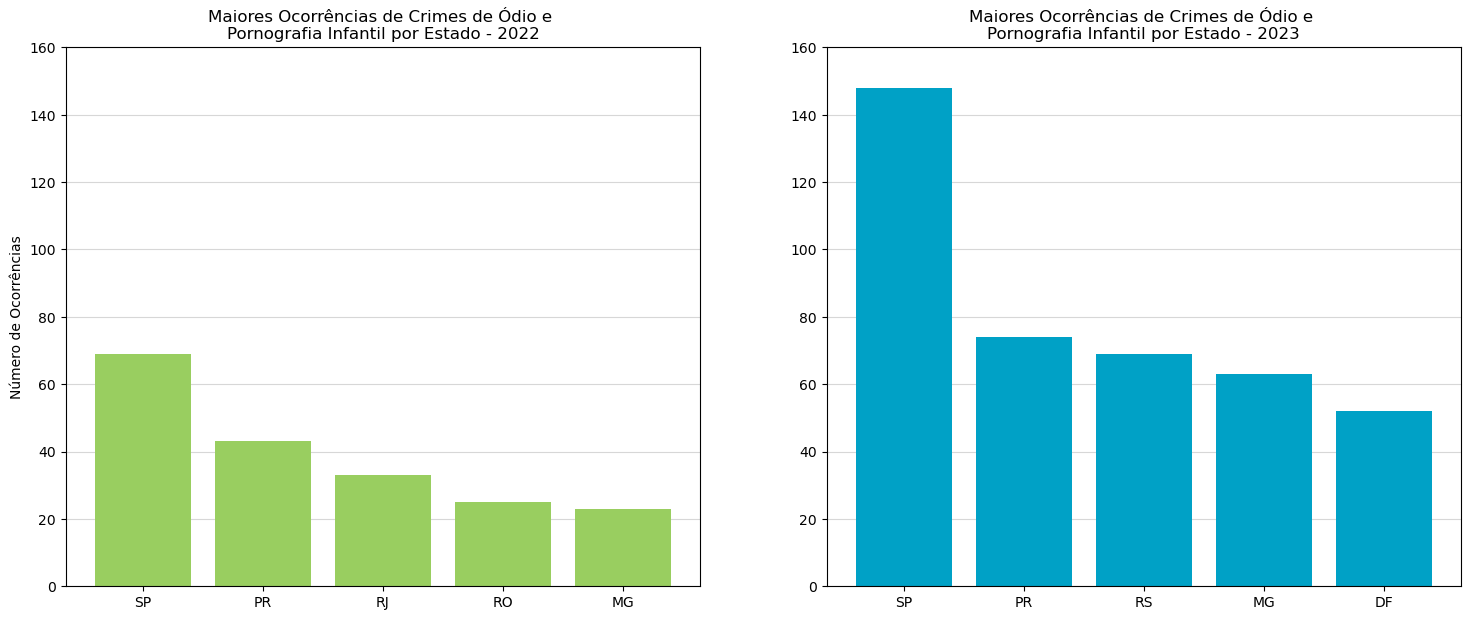

In [445]:
plt.figure(figsize=(18,7))
plt.subplot(1, 2, 1)
plt.bar(x='UF', height='Estado', color='#99ce60', data=odio_22)
plt.title('Maiores Ocorrências de Crimes de Ódio e \nPornografia Infantil por Estado - 2022')
plt.ylabel('Número de Ocorrências')
plt.ylim(0, 160)
plt.grid(axis='y', alpha=0.5, zorder=0)
plt.gca().set_axisbelow(True)
plt.subplot(1, 2, 2)
plt.bar(x='UF', height='Estado', color='#00A1C6', data=odio_23)
plt.title('Maiores Ocorrências de Crimes de Ódio e \nPornografia Infantil por Estado - 2023')
plt.ylim(0, 160)
plt.grid(axis='y', alpha=0.5, zorder=0)
plt.gca().set_axisbelow(True)

- #### Total de operações de fronteira por crime

In [25]:
%%sql
SELECT Crime, count(Fronteira) as 'Fronteira'
FROM FEDERAL
WHERE Fronteira <> 'Não'
GROUP BY Crime
ORDER BY count(Fronteira) DESC

 * sqlite:///dataframe_01.db
Done.


Crime,Fronteira
Crimes Fazendários,1104
Tráfico de Drogas,1063
Crimes Ambientais e Contra o Patrimônio Cultural,371
Tráfico de Armas,84
Crimes de Ódio e Pornografia Infantil,69
Crimes Contra o Patrimônio,67
Crimes Financeiros,52
Crimes Contra Direitos Humanos,48
Crimes Eleitorais,21
Crimes de Corrupção,20


In [23]:
top_estados = pd.read_sql_query("SELECT UF, count(UF) as 'Crimes Fazendários em Fronteira' FROM FEDERAL WHERE Crime = 'Crimes Fazendários' AND Fronteira <> 'Não' GROUP BY UF ORDER BY count(UF) DESC LIMIT 5", con=con)
top_estados.set_index('UF', inplace=True)
top_estados

,Crimes Fazendários em Fronteira
UF,
PR,472
MS,205
RS,176
RO,77
SC,76


In [25]:
top_paises = pd.read_sql_query("SELECT Fronteira, count(Fronteira) as 'Crimes Fazendários por País' FROM FEDERAL WHERE Crime = 'Crimes Fazendários' AND Fronteira <> 'Não' GROUP BY Fronteira ORDER BY count(Fronteira) DESC LIMIT 5", con=con)
top_paises.set_index('Fronteira', inplace=True)
top_paises

,Crimes Fazendários por País
Fronteira,
Paraguai,666
Argentina,193
Bolívia,133
Uruguai,73
Guiana,24


In [27]:
droga_estados = pd.read_sql_query("SELECT UF, count(UF) as 'Tráfico de Drogas em Fronteira' FROM FEDERAL WHERE Crime = 'Tráfico de Drogas' AND Fronteira <> 'Não' GROUP BY UF ORDER BY count(UF) DESC LIMIT 5", con=con)
droga_estados.set_index('UF', inplace=True)
droga_estados

,Tráfico de Drogas em Fronteira
UF,
MS,457
PR,152
RO,115
AC,99
RS,69


In [29]:
droga_paises = pd.read_sql_query("SELECT Fronteira, count(Fronteira) as 'Tráfico de Drogas por País' FROM FEDERAL WHERE Crime = 'Tráfico de Drogas' AND Fronteira <> 'Não' GROUP BY Fronteira ORDER BY count(Fronteira) DESC LIMIT 5", con=con)
droga_paises.set_index('Fronteira', inplace=True)
droga_paises

,Tráfico de Drogas por País
Fronteira,
Paraguai,478
Bolívia,388
Peru,66
Uruguai,52
Colômbia,39


In [31]:
ambiental_estados = pd.read_sql_query("SELECT UF, count(UF) as 'Crimes Ambientais em Fronteira' FROM FEDERAL WHERE Crime = 'Crimes Ambientais e Contra o Patrimônio Cultural' AND Fronteira <> 'Não' GROUP BY UF ORDER BY count(UF) DESC LIMIT 5", con=con)
ambiental_estados.set_index('UF', inplace=True)
ambiental_estados

,Crimes Ambientais em Fronteira
UF,
RR,136
RS,79
RO,71
MS,22
SC,16


In [33]:
ambiental_paises = pd.read_sql_query("SELECT Fronteira, count(Fronteira) as 'Crimes Ambientais por País' FROM FEDERAL WHERE Crime = 'Crimes Ambientais e Contra o Patrimônio Cultural' AND Fronteira <> 'Não' GROUP BY Fronteira ORDER BY count(Fronteira) DESC LIMIT 5", con=con)
ambiental_paises.set_index('Fronteira', inplace=True)
ambiental_paises

,Crimes Ambientais por País
Fronteira,
Guiana,114
Bolívia,86
Argentina,82
Paraguai,25
Uruguai,24


Text(0.5, 1.0, 'Top 5 Fronteiras em Crimes Fazendários')

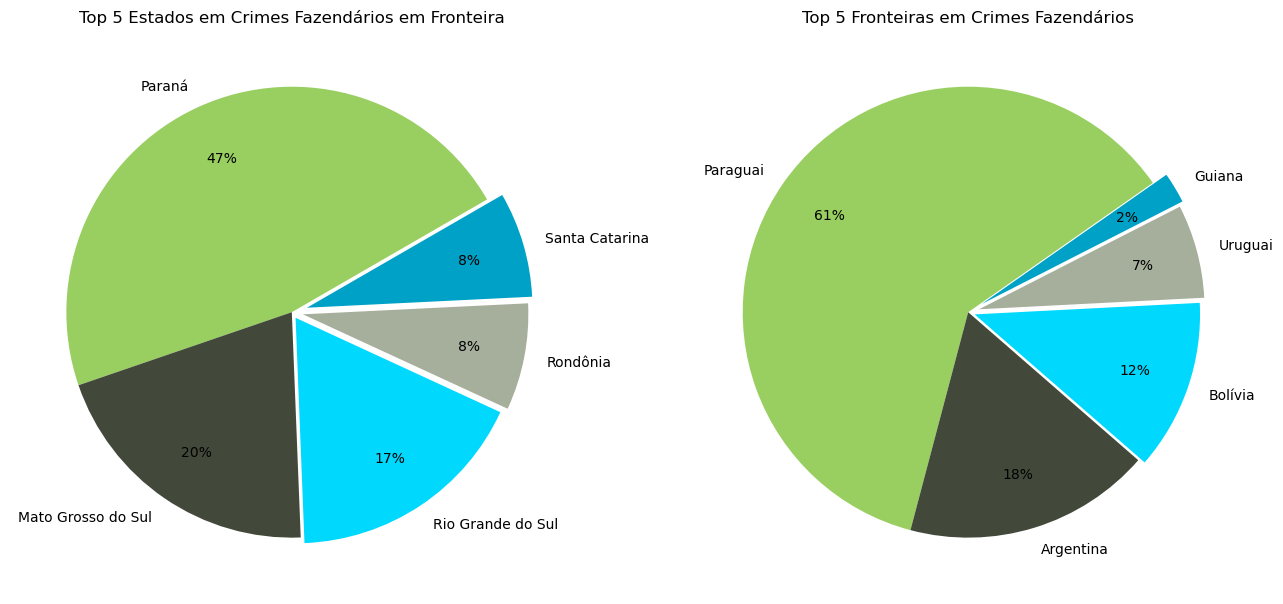

In [35]:
cores = ['#99ce60', '#42493A', '#00D8FE', '#A6AE9C', '#00A1C6']
xplosao = [0, 0, 0.03, 0.05, 0.07]
estados = ['Paraná', 'Mato Grosso do Sul', 'Rio Grande do Sul', 'Rondônia', 'Santa Catarina']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.pie(top_estados['Crimes Fazendários em Fronteira'], colors=cores, labels=estados, explode=xplosao, autopct='%1.0f%%', pctdistance=0.75, startangle=30)
plt.title("Top 5 Estados em Crimes Fazendários em Fronteira")
#plt.legend(title="ESTADO", labels=top_estados.index)
plt.subplot(1, 2, 2)
plt.pie(top_paises['Crimes Fazendários por País'], colors=cores, labels=top_paises.index, explode=xplosao, autopct="%1.0f%%", pctdistance=0.75, startangle=35)
plt.title("Top 5 Fronteiras em Crimes Fazendários")

**Crimes contra a Receita Federal**

Crimes fazendários, relacionados a infrações de ordem tributária, acontecem em sua grande maioria nas mesmas regiões que o tráfico de drogas.<br>

Ao verificarmos por nação, o **Paraguai** é responsável por **mais de 60%** de todos os registros de crimes fazendários das cinco principais fronteiras.<br>
O governo paraguaio é notoriamente conhecido pela baixa tributação aos produtos de fabricantes estrangeiros, além da baixa margem de lucro praticada por muitas lojas do país, abaixo dos 10%. Somando-se a isto os altos valores de importação no Brasil, não é de se surpreender que a grande maioria de produtos que entram no território nacional sem pagar imposto sejam de origem paraguaia.

Dentre os 5 principais Estados, o **Paraná** destaca-se em primeiro, **com 47%** dos registros, e o **Mato Grosso do Sul** fica em segundo, com **20%** do total. Ambos os Estados fazem fronteira com o Paraguai.<br>
Também destaca-se toda a **Região Sul** como uma porta de entrada para possíveis crimes de descaminho e contrabando, com as seguintes posições por Estado:

1º lugar - Paraná - 472 ocorrências;<br>
3º lugar - Rio Grande do Sul - 176 ocorrências;<br>
5º lugar - Santa Catarina - 76 ocorrências.

Text(0.5, 1.0, 'Top 5 Fronteiras em Tráfico de Drogas')

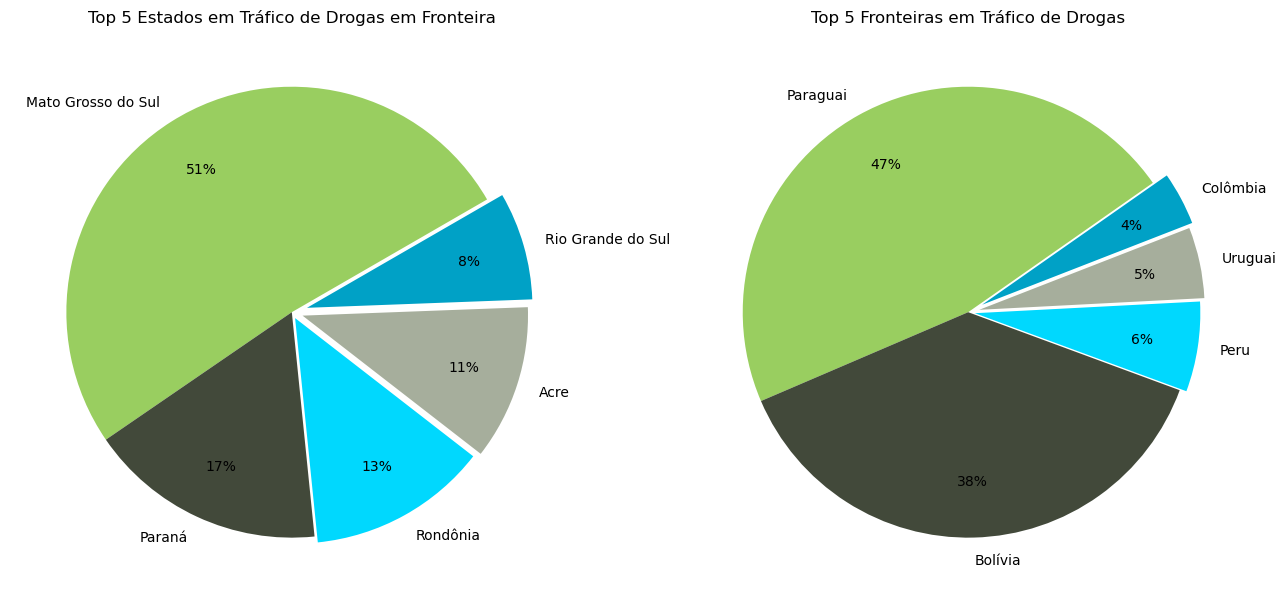

In [76]:
estados_droga = ['Mato Grosso do Sul', 'Paraná', 'Rondônia', 'Acre', 'Rio Grande do Sul']

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pie(droga_estados['Tráfico de Drogas em Fronteira'], colors=cores, labels=estados_droga, explode=xplosao, autopct='%1.0f%%', pctdistance=0.75, startangle=30)
plt.title("Top 5 Estados em Tráfico de Drogas em Fronteira")

plt.subplot(1, 2, 2)
plt.pie(droga_paises['Tráfico de Drogas por País'], colors=cores, labels=droga_paises.index, explode=xplosao, autopct="%1.0f%%", pctdistance=0.75, startangle=35)
plt.title("Top 5 Fronteiras em Tráfico de Drogas")

**Mapa do Tráfico**

Ao verificar os principais Estados onde ocorrem tráfico de drogas em fronteiras com outros países, fica clara uma **tendência** de entrada destas substâncias pelas **regiões Sul e Centro-Oeste** do Brasil, com grande foco em Mato Grosso do Sul, com 457 ocorrências, e Paraná, com 152 ocorrências.

**Paraguai** e **Bolívia** são os dois **maiores fornecedores de drogas ao Brasil**, representando impressionantes **85% do total** das cinco principais fronteiras onde este tipo de crime acontece. O Mato Grosso do Sul faz divisa com ambos os países, o que mostra a razão do Estado ser a principal porta de entrada das drogas no nosso país.

A via de entrada ao norte do Brasil, constituída principalmente por **Rondônia, Acre e Amazonas**, tem um total agregado de **265** registros, o que representa pouco mais da metade dos números de Mato Grosso do Sul.

Os registros de tráfico na fronteira do **Uruguai** representam apenas **5% dos top cinco**, indicando que a regulamentação da maconha no vizinho do Brasil não causou um aumento significativo neste tipo de crime.

Text(0.5, 1.0, 'Top 5 Fronteiras em Crimes Ambientais')

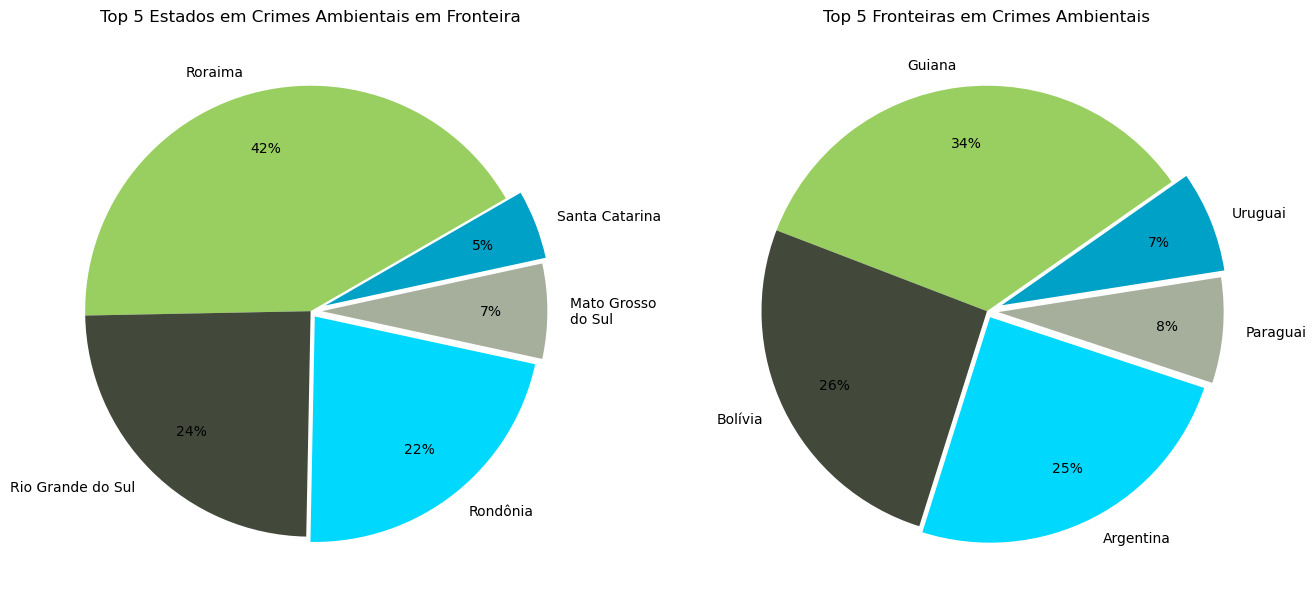

In [37]:
estados_ambiental = ['Roraima', 'Rio Grande do Sul', 'Rondônia', 'Mato Grosso\ndo Sul', 'Santa Catarina']

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pie(ambiental_estados['Crimes Ambientais em Fronteira'], colors=cores, labels=estados_ambiental, explode=xplosao, autopct='%1.0f%%', pctdistance=0.75, startangle=30)
plt.title("Top 5 Estados em Crimes Ambientais em Fronteira")

plt.subplot(1, 2, 2)
plt.pie(ambiental_paises['Crimes Ambientais por País'], colors=cores, labels=ambiental_paises.index, explode=xplosao, autopct="%1.0f%%", pctdistance=0.75, startangle=35)
plt.title("Top 5 Fronteiras em Crimes Ambientais")

**Crimes Ambientais e Contra o Patrimônio Cultural**

Os cinco principais países em Crimes Ambientais fazem fronteira com os cinco principais Estados desta categoria. Não indica necessariamente que a maior parte dos Crimes Ambientais nestes Estados aconteçam em fronteira.

- #### As 10 maiores operações não-fronteiriças em valores apreendidos

In [31]:
%%sql
SELECT *
FROM FEDERAL
WHERE Fronteira = 'Não'
ORDER BY [Valores Apreendidos (R$)] DESC
LIMIT 10

 * sqlite:///dataframe_01.db
Done.


index,Data do Inicio,Data da Deflagracao,Tipo de Operacao,Crime,UF,Fronteira,Prisao Flagrante,Prisao Preventiva,Prisao Temporaria,Mandados,Valores Apreendidos (R$),Prejuizos a Uniao (R$),Ano_22,Ano_23
2506,2022-04-18,2022-04-18,Operacao Simples,Crimes Ambientais e Contra o Patrimônio Cultural,BA,Não,0,0,0,0,1431200000.0,0.0,1,0
6561,2022-08-17,2022-08-17,Operacao Especial,Crimes Fazendários,RJ,Não,0,2,0,26,561729480.0,0.0,1,0
12859,2020-12-02,2023-04-19,Operacao Especial,Tráfico de Drogas,SP,Não,0,2,0,7,480200000.0,0.0,0,1
18026,2021-01-22,2023-11-28,Operacao Especial,Crimes Financeiros,SC,Não,0,0,0,28,350208273.14,0.0,0,1
5820,2022-05-11,2022-07-07,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,SP,Não,0,0,0,16,301012326.0,1135209997.0,1,0
4130,2022-06-28,2022-06-28,Operacao Comum,Crimes Financeiros,ES,Não,0,0,0,4,290000530.0,0.0,1,0
8177,2020-11-11,2022-10-25,Operacao Especial,Crimes Financeiros,SC,Não,0,0,0,7,271551254.0,0.0,1,0
19389,2022-12-11,2023-12-07,Operacao Especial,Crimes Contra o Patrimônio,BA,Não,1,6,0,60,200038394.0,0.0,0,1
17343,2023-09-27,2023-10-18,Operacao Especial,Crimes Fazendários,RJ,Não,0,0,0,10,159932000.0,0.0,0,1
19449,2023-10-10,2023-12-06,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,PA,Não,2,0,0,20,116502471.0,0.0,0,1


In [592]:
# Criar DF com query SQL
valores_int = pd.read_sql_query("SELECT * FROM FEDERAL WHERE Fronteira = 'Não' ORDER BY [Valores Apreendidos (R$)] DESC LIMIT 10", con=con)

In [594]:
# Criar lista para xlabels:
valores_int_xlabel = valores_int[['Crime', 'UF']]

lista_xlabel = []
for i in valores_int_xlabel.index:
    lista_xlabel.append(valores_int_xlabel['Crime'][i] + "\n" + valores_int_xlabel['UF'][i])

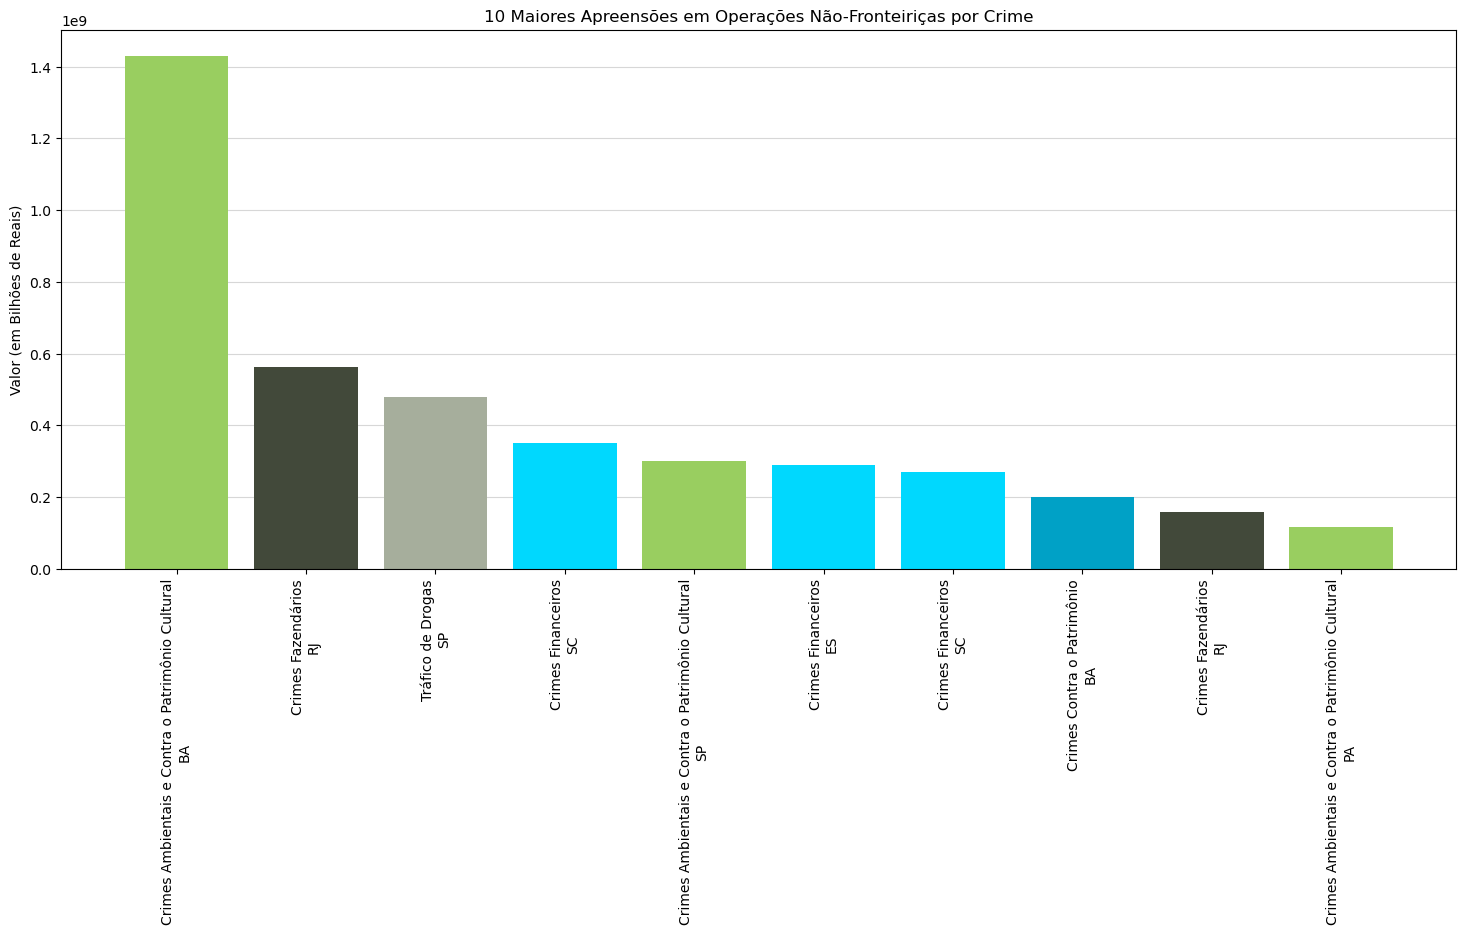

In [596]:
cores = ['#99ce60', '#42493A', '#A6AE9C', '#00D8FE', '#99ce60', '#00D8FE', '#00D8FE', '#00A1C6', '#42493A', '#99ce60']
plt.figure(figsize=(18,7))
plt.bar(x="Data da Deflagracao", height="Valores Apreendidos (R$)", color=cores, data=valores_int)
plt.title("10 Maiores Apreensões em Operações Não-Fronteiriças por Crime")
plt.ylabel("Valor (em Bilhões de Reais)")
plt.xticks(ticks=range(0, 10), labels=lista_xlabel, rotation=90)
plt.grid(axis='y', alpha=0.5, zorder=0)
plt.gca().set_axisbelow(True)

- #### As 10 maiores operações em valores apreendidos em fronteira

In [37]:
%%sql
SELECT *
FROM FEDERAL
WHERE Fronteira <> 'Não'
ORDER BY [Valores Apreendidos (R$)] DESC
LIMIT 10

 * sqlite:///dataframe_01.db
Done.


index,Data do Inicio,Data da Deflagracao,Tipo de Operacao,Crime,UF,Fronteira,Prisao Flagrante,Prisao Preventiva,Prisao Temporaria,Mandados,Valores Apreendidos (R$),Prejuizos a Uniao (R$),Ano_22,Ano_23
5304,2021-02-05,2022-07-22,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,RO,Bolívia,0,5,0,66,828461903.0,0.0,1,0
13091,2020-12-07,2023-04-12,Operacao Especial,Tráfico de Drogas,SC,Uruguai,3,29,0,98,304737382.0,0.0,0,1
8392,2021-08-20,2022-10-19,Operacao Especial,Crimes Financeiros,MS,Paraguai,0,6,0,41,177148645.0,0.0,1,0
16191,2020-09-14,2023-09-20,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,RR,Venezuela,0,1,0,19,97425759.43,0.0,0,1
18736,2021-11-01,2023-11-08,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,SP,Paraguai,2,0,0,56,90180000.0,8700000000.0,0,1
17649,2023-10-09,2023-10-09,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,RO,Bolívia,0,0,0,0,89000000.0,7000000.0,0,1
16193,2021-08-06,2023-09-20,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,RR,Venezuela,1,1,0,21,71985329.79,0.0,0,1
17608,2023-10-10,2023-10-10,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,RO,Bolívia,0,0,0,0,71000000.0,10000000.0,0,1
3545,2021-06-11,2022-05-16,Operacao Especial,Tráfico de Drogas,MT,Bolívia,1,8,0,56,60350000.0,0.0,1,0
11494,2022-09-06,2023-02-14,Operacao Especial,Crimes Financeiros,RS,Argentina,1,0,0,8,59128103.0,0.0,0,1


In [408]:
# Criar DF com valores da query acima
valores_front = pd.read_sql_query("SELECT * FROM FEDERAL WHERE Fronteira <> 'Não' ORDER BY [Valores Apreendidos (R$)] DESC LIMIT 10", con=con)

In [410]:
# Criar uma coluna com valores únicos (datas repetem)
valores_front['Unico'] = range(0, 10)

In [432]:
# Criar lista para xlabels:
valores_front_xlabel = valores_front[['Crime', 'UF', 'Fronteira']]

lista_xlabel = []
for j in valores_int_xlabel.index:
    lista_xlabel.append(valores_front_xlabel['Crime'][j] + "\n" + valores_front_xlabel['UF'][j] + "\n" + valores_front_xlabel['Fronteira'][j])

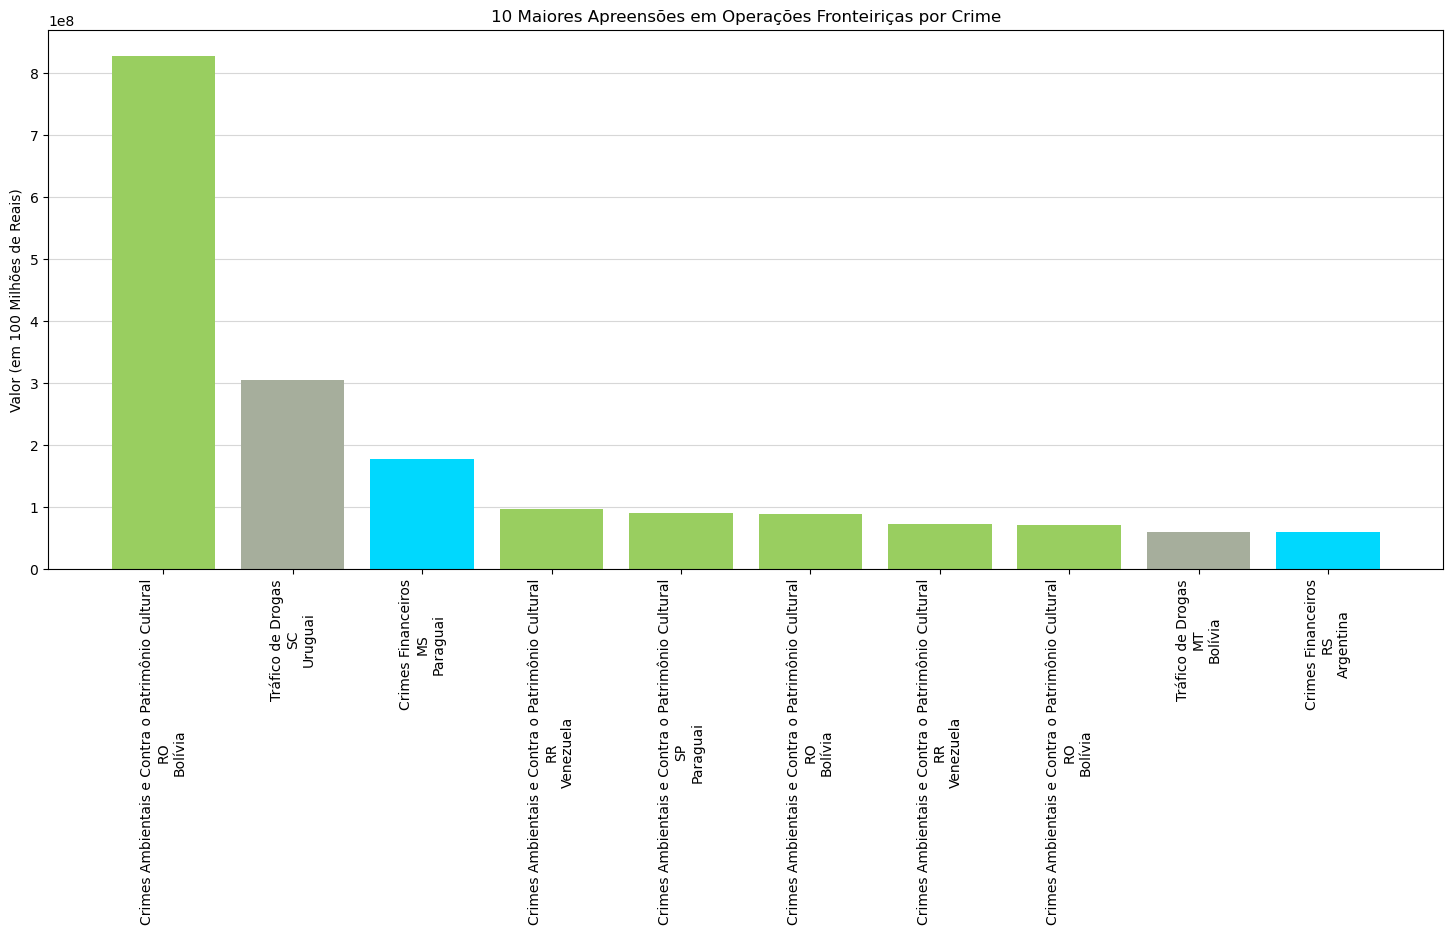

In [434]:
cores = ['#99ce60', '#A6AE9C', '#00D8FE', '#99ce60', '#99ce60', '#99ce60', '#99ce60', '#99ce60', '#A6AE9C', '#00D8FE']
plt.figure(figsize=(18,7))
plt.bar(x='Unico', height='Valores Apreendidos (R$)', color=cores, data=valores_front)
plt.title("10 Maiores Apreensões em Operações Fronteiriças por Crime")
plt.ylabel("Valor (em 100 Milhões de Reais)")
plt.xticks(ticks=range(0, 10), labels=lista_xlabel, rotation=90)
plt.grid(axis='y', alpha=0.5, zorder=0)
plt.gca().set_axisbelow(True)

**Tipo de Crime x Apreensões**

Ao analisarmos as maiores apreensões em termos de valores, as operações não-fronteiriças têm **pouca relação com os Estados** e **maior relação com o tipo de crime praticado**.

Entre as 10 maiores operações fronteiriças, 3 são de **Crimes Ambientais e Contra o Patrimônio Cultural**, que juntas somam mais de **1,8 bilhão de Reais** em apreensão.

O cenário fica ainda mais evidente em operações de fronteira: **6 das 10 maiores apreensões** são de Crimes Ambientais e Contra o Patrimônio Cultural, totalizando mais de **1,2 bilhão de Reais**. Aqui, nota-se uma certa **relação entre Crimes Ambientais** e os Estados de **Rondônia** (3 casos) e **Roraima** (2 casos), em fronteira com Bolívia e Venezuela, respectivamente. 

- #### As 10 maiores operações não-fronteiriças em prejuízos à União

In [261]:
%%sql
SELECT [index], MAX([Prejuizos a Uniao (R$)])
FROM FEDERAL
WHERE Fronteira = 'Não'

 * sqlite:///dataframe_01.db
Done.


index,MAX([Prejuizos a Uniao (R$)])
17778,16965551060.0


In [263]:
%%sql
SELECT *
FROM FEDERAL
WHERE [index] = 17778

 * sqlite:///dataframe_01.db
Done.


index,Data do Inicio,Data da Deflagracao,Tipo de Operacao,Crime,UF,Fronteira,Prisao Flagrante,Prisao Preventiva,Prisao Temporaria,Mandados,Valores Apreendidos (R$),Prejuizos a Uniao (R$),Ano_22,Ano_23
17778,2023-08-30,2023-10-04,Operacao Especial,Crimes de Corrupção,MT,Não,0,0,0,8,105950.0,16965551060.0,0,1


*Como não foram encontradas evidências de valores tão altos (R$16,9 bilhões) de prejuízos financeiros em MT, será considerado um valor outlier.*

In [126]:
%%sql
SELECT *
FROM FEDERAL
WHERE Fronteira = 'Não' AND [Prejuizos a Uniao (R$)] < 2289982355
ORDER BY [Prejuizos a Uniao (R$)] DESC
LIMIT 10

 * sqlite:///dataframe_01.db
Done.


index,Data do Inicio,Data da Deflagracao,Tipo de Operacao,Crime,UF,Fronteira,Prisao Flagrante,Prisao Preventiva,Prisao Temporaria,Mandados,Valores Apreendidos (R$),Prejuizos a Uniao (R$),Ano_22,Ano_23
11287,2022-10-25,2023-02-22,Operacao Simples,Crimes Fazendários,RN,Não,0,0,0,0,52648198.0,2189982355.0,0,1
14783,2023-05-09,2023-06-20,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,MT,Não,0,0,0,0,0.0,1400000000.0,0,1
5820,2022-05-11,2022-07-07,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,SP,Não,0,0,0,16,301012326.0,1135209997.0,1,0
2041,2022-01-03,2022-03-21,Operacao Especial,Crimes Previdenciários,SP,Não,0,0,0,3,0.0,1103718610.0,1,0
3381,2021-10-19,2022-05-20,Operacao Especial,Crimes de Corrupção,CE,Não,0,0,0,19,930000.0,1000000000.0,1,0
7988,2022-01-25,2022-09-01,Operacao Especial,Crimes de Corrupção,RJ,Não,0,0,0,18,3497291.0,500000000.0,1,0
18527,2019-07-29,2023-11-14,Operacao Especial,Crimes Financeiros,RS,Não,0,0,0,26,3188000.0,451097903.65,0,1
11681,2022-10-10,2023-02-09,Operacao Especial,Crimes Fazendários,MG,Não,0,0,0,10,4447734.0,371862262.0,0,1
12523,2021-11-24,2023-03-16,Operacao Especial,Crimes Fazendários,SP,Não,0,0,0,14,1308287.0,300000000.0,0,1
11452,2023-02-15,2023-02-15,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,PA,Não,0,0,2,26,12150000.0,200000000.0,0,1


In [436]:
preju_int = pd.read_sql_query('SELECT * FROM FEDERAL WHERE Fronteira = "Não" AND [Prejuizos a Uniao (R$)] < 2289982355 ORDER BY [Prejuizos a Uniao (R$)] DESC LIMIT 10', con=con)

In [458]:
# Criar lista para xlabels:
preju_int_xlabel = preju_int[['Crime', 'UF']]

lista_xlabel = []
for k in preju_int_xlabel.index:
    lista_xlabel.append(preju_int_xlabel['Crime'][k] + "\n" + preju_int_xlabel['UF'][k])

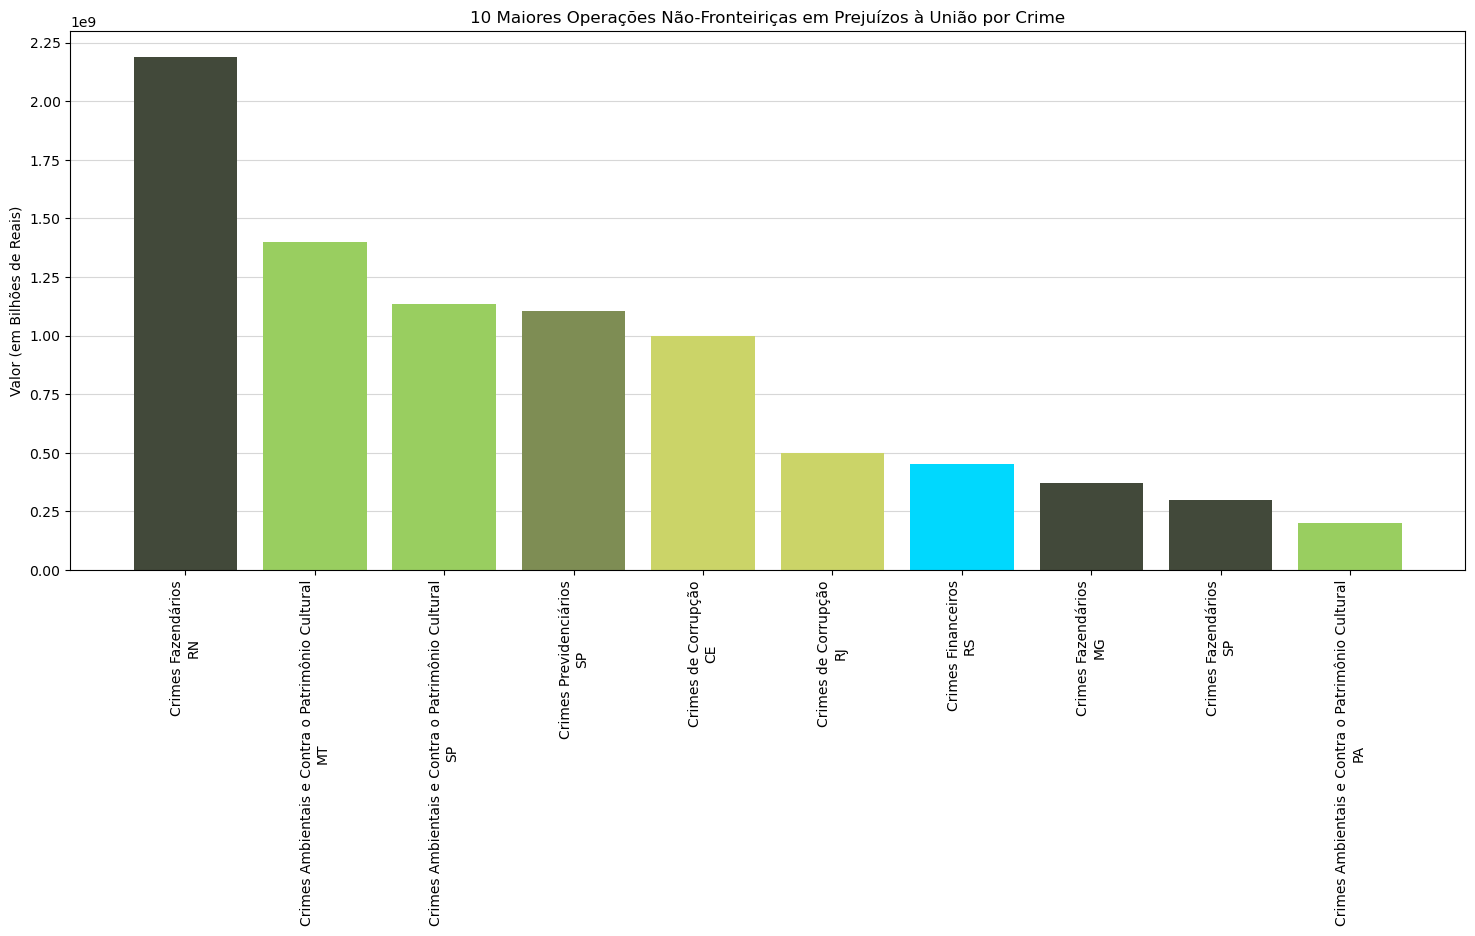

In [462]:
preju_int.sort_values('Prejuizos a Uniao (R$)', ascending=False, inplace=True)

cores = ['#42493A', '#99ce60', '#99ce60', '#7E8D54', '#CBD468', '#CBD468', '#00D8FE', '#42493A', '#42493A', '#99ce60']
plt.figure(figsize=(18,7))
plt.bar(x='Data da Deflagracao', height='Prejuizos a Uniao (R$)', color=cores, data=preju_int)
plt.title("10 Maiores Operações Não-Fronteiriças em Prejuízos à União por Crime")
plt.ylabel("Valor (em Bilhões de Reais)")
plt.yticks(range(0, 2500000000, 250000000))
plt.xticks(ticks=range(0, 10), labels=lista_xlabel, rotation=90)
plt.grid(axis='y', alpha=0.5, zorder=0)
plt.gca().set_axisbelow(True)

- #### As 10 maiores operações em prejuízos à União em fronteira

In [269]:
%sql SELECT [index], MAX([Prejuizos a Uniao (R$)]) FROM FEDERAL WHERE Fronteira <> 'Não'

 * sqlite:///dataframe_01.db
Done.


index,MAX([Prejuizos a Uniao (R$)])
18736,8700000000.0


In [271]:
%sql SELECT * FROM FEDERAL WHERE [index] = 18736

 * sqlite:///dataframe_01.db
Done.


index,Data do Inicio,Data da Deflagracao,Tipo de Operacao,Crime,UF,Fronteira,Prisao Flagrante,Prisao Preventiva,Prisao Temporaria,Mandados,Valores Apreendidos (R$),Prejuizos a Uniao (R$),Ano_22,Ano_23
18736,2021-11-01,2023-11-08,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,SP,Paraguai,2,0,0,56,90180000.0,8700000000.0,0,1


*Como não foram encontradas evidências de valores tão altos (R$8,7 bilhões) de prejuízos financeiros em SP, será considerado um valor outlier.*

In [276]:
%%sql
SELECT *
FROM FEDERAL
WHERE Fronteira <> 'Não' AND [Prejuizos a Uniao (R$)] < 8700000000
ORDER BY [Prejuizos a Uniao (R$)] DESC
LIMIT 10

 * sqlite:///dataframe_01.db
Done.


index,Data do Inicio,Data da Deflagracao,Tipo de Operacao,Crime,UF,Fronteira,Prisao Flagrante,Prisao Preventiva,Prisao Temporaria,Mandados,Valores Apreendidos (R$),Prejuizos a Uniao (R$),Ano_22,Ano_23
12363,2023-02-16,2023-03-21,Operacao Especial,Crimes Financeiros,RS,Uruguai,0,0,1,4,40892938.0,2388056324.0,0,1
10058,2022-05-23,2022-12-07,Operacao Especial,Crimes de Corrupção,MG,Uruguai,0,0,3,6,115000.0,1000010000.0,1,0
4706,2022-02-11,2022-06-09,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,RO,Bolívia,0,0,0,19,21534845.0,289000000.0,1,0
8590,2022-02-15,2022-10-13,Operacao Especial,Crimes Financeiros,RS,Uruguai,0,1,4,9,6954274.0,200000000.0,1,0
6818,2020-08-27,2022-08-09,Operacao Especial,Crimes Fazendários,PR,Paraguai,0,0,0,12,2514996.0,156621477.0,1,0
16971,2023-10-17,2023-10-26,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,MT,Bolívia,1,0,0,5,931289.5,128851655.5,0,1
6817,2020-08-27,2022-08-09,Operacao Especial,Crimes Fazendários,PR,Paraguai,1,2,0,19,5308406.0,105524635.0,1,0
17253,2023-03-02,2023-10-19,Operacao Especial,Crimes Fazendários,PR,Paraguai,6,52,0,95,2054790.48,93500000.0,0,1
6821,2020-08-27,2022-08-09,Operacao Especial,Crimes Fazendários,PR,Paraguai,0,0,0,3,2014783.0,65126716.0,1,0
10201,2022-10-06,2022-12-01,Operacao Especial,Crimes Ambientais e Contra o Patrimônio Cultural,SP,Bolívia,3,7,4,48,52100000.0,62200000.0,1,0


In [464]:
preju_front = pd.read_sql_query("SELECT * FROM FEDERAL WHERE Fronteira <> 'Não' AND [Prejuizos a Uniao (R$)] < 8700000000 ORDER BY [Prejuizos a Uniao (R$)] DESC LIMIT 10", con=con)

In [466]:
preju_front['Unico'] = range(0, 10)

In [476]:
# Criar lista para xlabels:
preju_front_xlabel = preju_front[['Crime', 'UF', 'Fronteira']]

lista_xlabel = []
for l in preju_front_xlabel.index:
    lista_xlabel.append(preju_front_xlabel['Crime'][l] + "\n" + preju_front_xlabel['UF'][l] + "\n" + preju_front_xlabel['Fronteira'][l])

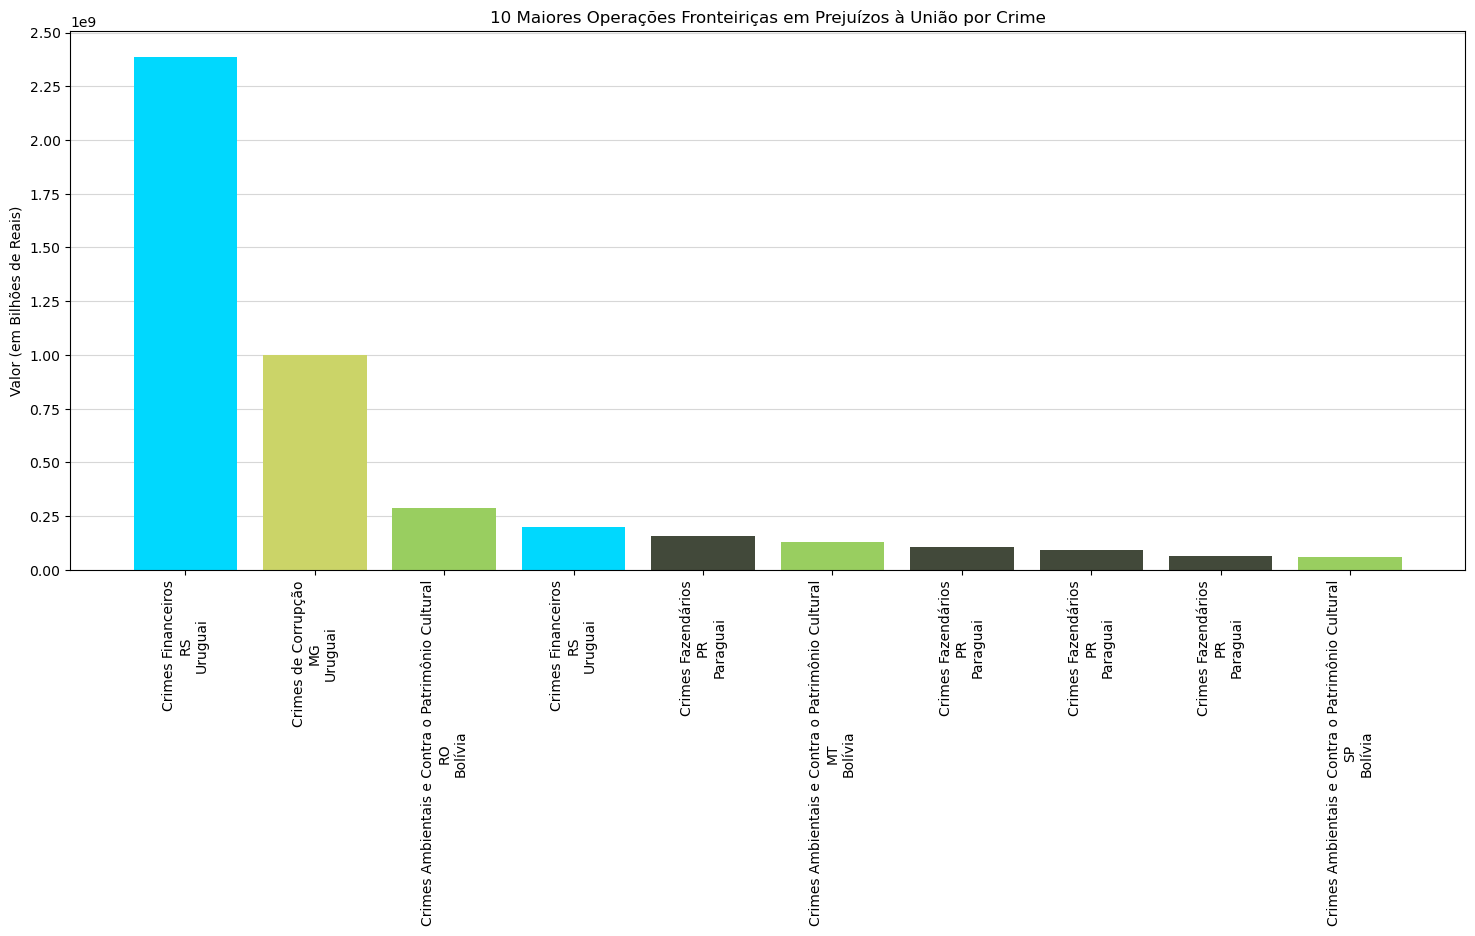

In [478]:
cores = ['#00D8FE', '#CBD468', '#99ce60', '#00D8FE', '#42493A', '#99ce60', '#42493A', '#42493A', '#42493A', '#99ce60']
plt.figure(figsize=(18,7))
plt.bar(x='Unico', height='Prejuizos a Uniao (R$)', color=cores, data=preju_front)
plt.title("10 Maiores Operações Fronteiriças em Prejuízos à União por Crime")
plt.ylabel("Valor (em Bilhões de Reais)")
plt.yticks(range(0, 2750000000, 250000000))
plt.xticks(ticks=range(0, 10), labels=lista_xlabel, rotation=90)
plt.grid(axis='y', alpha=0.5, zorder=0)
plt.gca().set_axisbelow(True)

**Crimes Ambientais e Fazendários: Os destaques em prejuízos à União**

Em crimes não-fronteiriços, os **Crimes Fazendários** e **Crimes Ambientais e Contra o Patrimônio Cultural** apresentaram números muito próximos: **3 em cada 10 registros** para cada categoria e um total de prejuízos acumulados equivalentes a **2,8 bilhões e 2,7 bilhões de Reais**, respectivamente.

Os **Crimes Ambientais e Contra o Patrimônio Cultural** somam **3 casos**, **480 milhões de Reais** em prejuízo e, apesar de acontecerem em diferentes Estados, todas as operações tiveram origem na fronteira com a **Bolívia**.

Entre os **Crimes Fazendários**, foram **4 registros**, totalizando **420 milhões de Reais**. Todos os casos aconteceram entre as **fronteiras do Paraná e Paraguai**, indicando possível relação entre as variáveis. 

- #### Quantidade de Operações por Estado

In [627]:
ops_estado = pd.read_sql_query('SELECT UF, count([index]) as "Total de Operações" FROM FEDERAL GROUP BY UF ORDER BY count([index]) DESC LIMIT 10', con=con)
ops_estado

,UF,Total de Operações
0,SP,2839
1,PR,2240
2,MS,2043
3,RS,1520
4,MG,1369
5,RJ,886
6,RO,659
7,PA,650
8,SC,634
9,RR,611


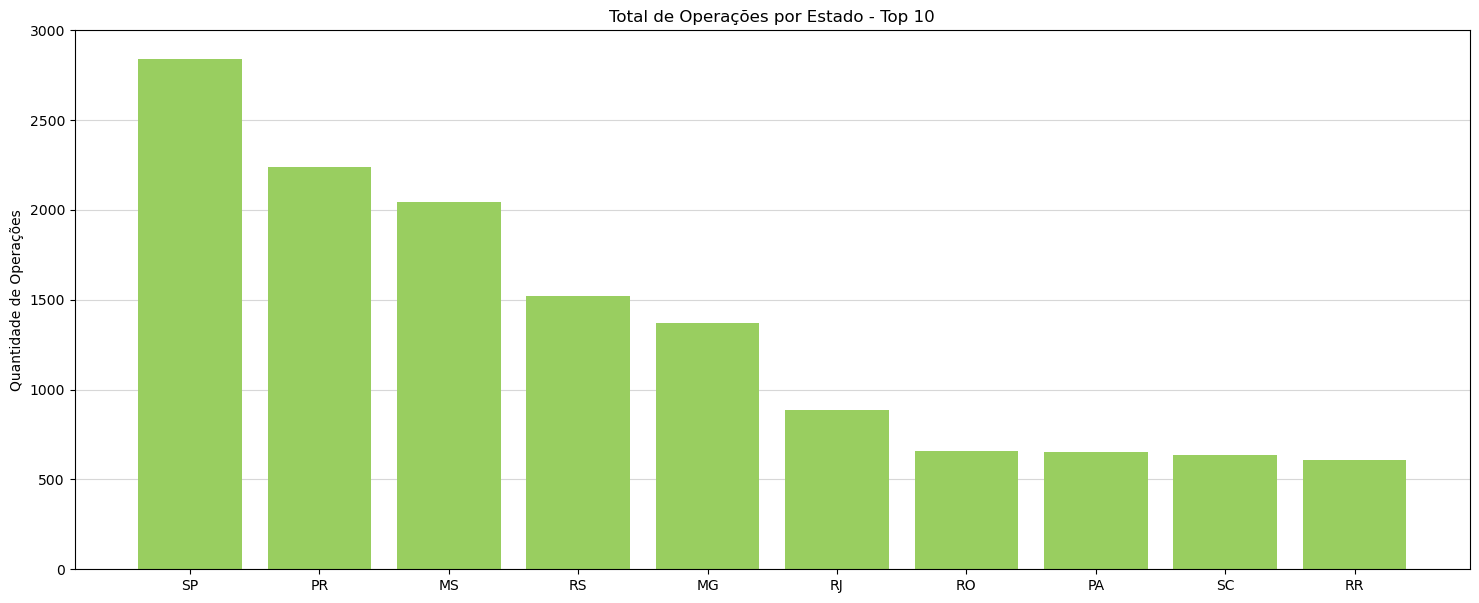

In [641]:
plt.figure(figsize=(18,7))
plt.bar(x='UF', height='Total de Operações', color='#99ce60', data=ops_estado)
plt.title('Total de Operações por Estado - Top 10')
plt.yticks(range(0, 3500, 500))
plt.ylabel('Quantidade de Operações')
plt.grid(axis='y', alpha=0.5, zorder=0)
plt.gca().set_axisbelow(True)